In [36]:
import json
import os
from pathlib import Path
import time
import copy

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

In [2]:
SIZE = 224
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'

In [3]:
!ls ../input/pascal/pascal

Annotations  SegmentationClass	 pascal_test2007.json	tmp
ImageSets    SegmentationObject  pascal_train2007.json
JPEGImages   models		 pascal_val2007.json


In [4]:
PATH = Path('../input/pascal/pascal')
list(PATH.iterdir())

[PosixPath('../input/pascal/pascal/tmp'),
 PosixPath('../input/pascal/pascal/SegmentationObject'),
 PosixPath('../input/pascal/pascal/pascal_train2007.json'),
 PosixPath('../input/pascal/pascal/Annotations'),
 PosixPath('../input/pascal/pascal/SegmentationClass'),
 PosixPath('../input/pascal/pascal/ImageSets'),
 PosixPath('../input/pascal/pascal/pascal_val2007.json'),
 PosixPath('../input/pascal/pascal/models'),
 PosixPath('../input/pascal/pascal/JPEGImages'),
 PosixPath('../input/pascal/pascal/pascal_test2007.json')]

In [5]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [9]:
train_data[ANNOTATIONS][:1]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0}]

In [10]:
train_data[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}]

In [11]:
len(train_data[CATEGORIES])

20

In [12]:
next(iter(train_data[CATEGORIES]))

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [13]:
categories = {c[ID]:c[NAME] for c in train_data[CATEGORIES]}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [14]:
len(categories)

20

In [15]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('../input/pascal/pascal/JPEGImages/000318.jpg'),
 PosixPath('../input/pascal/pascal/JPEGImages/006438.jpg')]

In [16]:
train_filenames = {o[ID]:o[FILE_NAME] for o in train_data[IMAGES]}
print('length:', len(train_filenames))
image1_id, image1_fn = next(iter(train_filenames.items()))
image1_id, image1_fn

length: 2501


(12, '000012.jpg')

In [17]:
train_image_ids = [o[ID] for o in train_data[IMAGES]]
print('length:', len(train_image_ids))
train_image_ids[:5]

length: 2501


[12, 17, 23, 26, 32]

In [18]:
IMAGE_PATH

PosixPath('../input/pascal/pascal/JPEGImages')

In [19]:
image1_path = IMAGE_PATH/image1_fn
image1_path

PosixPath('../input/pascal/pascal/JPEGImages/000012.jpg')

In [20]:
str(image1_path)

'../input/pascal/pascal/JPEGImages/000012.jpg'

In [21]:
im = open_image(str(IMAGE_PATH/image1_fn))
print(type(im))

<class 'numpy.ndarray'>


In [22]:
im.shape

(333, 500, 3)

In [23]:
len(train_data[ANNOTATIONS])

7844

In [24]:
# get the biggest object label per image

In [25]:
train_data[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [26]:
bbox = train_data[ANNOTATIONS][0][BBOX]
bbox

[155, 96, 196, 174]

In [27]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

print(bbox)
print(fastai_bb(bbox))

[155, 96, 196, 174]
[ 96 155 269 350]


In [28]:
fbb = fastai_bb(bbox)
fbb

array([ 96, 155, 269, 350])

In [29]:
def fastai_bb_hw(bb):
    h= bb[3]-bb[1]+1
    w = bb[2]-bb[0]+1
    return [h,w]

fastai_bb_hw(fbb)

[196, 174]

In [30]:
def pascal_bb_hw(bb):
    return bb[2:]

pascal_bb_hw(bbox)

[196, 174]

In [31]:
train_image_w_area = {i:None for i in train_image_ids}
print(image1_id, train_image_w_area[image1_id])

12 None


In [32]:
for x in train_data[ANNOTATIONS]:
    bbox = x[BBOX]
    new_category_id = x[CATEGORY_ID]
    image_id = x[IMAGE_ID]
    h, w = pascal_bb_hw(bbox)
    new_area = h*w
    cat_id_area = train_image_w_area[image_id]
    if not cat_id_area:
        train_image_w_area[image_id] = (new_category_id, new_area)
    else:
        category_id, area = cat_id_area
        if new_area > area:
            train_image_w_area[image_id] = (new_category_id, new_area)

In [33]:
train_image_w_area[image1_id]

(7, 34104)

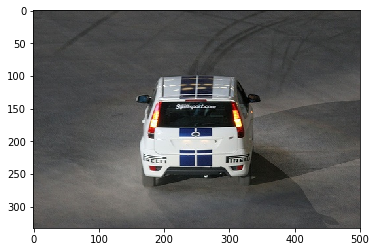

In [35]:
plt.imshow(im)

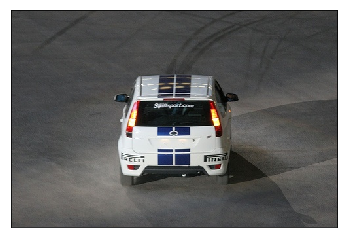

In [37]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

show_img(im)

In [38]:
# show_img(im)
# b = bb_hw(im0_a[0])
# draw_rect(ax, b)
image1_fn

'000012.jpg'

In [39]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [40]:
image1_id

12

In [41]:
image1_path

PosixPath('../input/pascal/pascal/JPEGImages/000012.jpg')

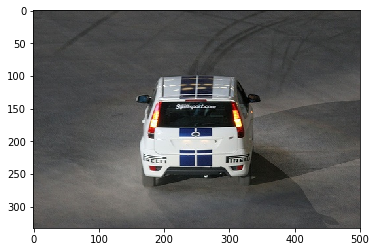

In [42]:
plt.imshow(open_image(str(image1_path)))

In [43]:
train_data[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

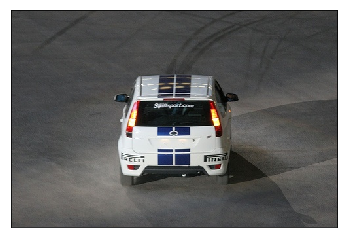

In [44]:
im = open_image(str(image1_path))
ax = show_img(im)

In [45]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [46]:
image1_ann = train_data[ANNOTATIONS][0]
b = fastai_bb(image1_ann[BBOX])
b

array([ 96, 155, 269, 350])

In [47]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

[155, 96, 196, 174]


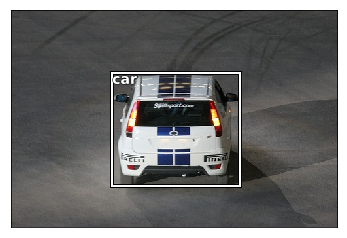

In [49]:
ax = show_img(im)
b = image1_ann[BBOX]
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[image1_ann[CATEGORY_ID]])

In [50]:
# create a Pandas dataframe for: image_id, filename, category
BIGGEST_OBJECT_CSV = '../input/pascal/pascal/tmp/biggest-object.csv'
IMAGE = 'image'
CATEGORY = 'category'

train_df = pd.DataFrame({
    IMAGE_ID: image_id,
    IMAGE: str(IMAGE_PATH/image_fn),
    CATEGORY: train_image_w_area[image_id][0]
} for image_id, image_fn in train_filenames.items())

train_df.head()

,category,image,image_id
0,7,../input/pascal/pascal/JPEGImages/000012.jpg,12
1,13,../input/pascal/pascal/JPEGImages/000017.jpg,17
2,15,../input/pascal/pascal/JPEGImages/000023.jpg,23
3,7,../input/pascal/pascal/JPEGImages/000026.jpg,26
4,1,../input/pascal/pascal/JPEGImages/000032.jpg,32


In [51]:
# NOTE: won't work in Kaggle Kernal b/c read-only file system
# train_df.to_csv(BIGGEST_OBJECT_CSV, index=False)

In [52]:
train_df.iloc[0]

category                                               7
image       ../input/pascal/pascal/JPEGImages/000012.jpg
image_id                                              12
Name: 0, dtype: object

In [53]:
len(train_df)

2501

In [54]:
class BiggestObjectDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im = open_image(self.df.iloc[idx][IMAGE]) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        category =  self.df.iloc[idx][CATEGORY]

        return image, category-1
    
dataset = BiggestObjectDataset(train_df)
inputs, label = dataset[0]

In [55]:
label

6

In [58]:
inputs.shape

(3, 224, 224)

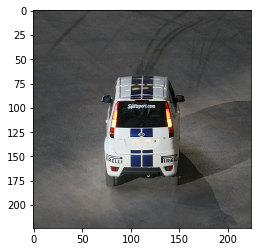

In [102]:
hwc_image = np.transpose(inputs, (1, 2, 0))
plt.imshow(hwc_image)

# DataLoader

In [104]:
BATCH_SIZE = 4
NUM_WORKERS = 4

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)

batch_inputs, batch_labels = next(iter(dataloader))

Process Process-21:
Process Process-24:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 110, in _worker_loop
    data_queue.put((idx, samples))
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/opt/conda/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 190, in reduce_storage
    fd, size = storage._share_fd_()
RuntimeError: unable to write to file </torch_182_746421049>
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstra

RuntimeError: DataLoader worker (pid 182) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [68]:
batch_inputs.size()

torch.Size([64, 3, 224, 224])

In [71]:
batch_labels

tensor([16, 10, 14,  5, 14,  3,  8, 14, 12,  6, 14,  6,  3, 11, 12, 14, 12, 17,
        17, 12, 18,  8, 14, 17, 11, 12, 14, 14, 14,  5, 14,  0,  6, 14, 10, 14,
        11, 12, 14, 14,  8, 13, 14,  0,  0,  3,  2, 17, 13,  7, 14, 12,  5, 16,
        12,  6, 14,  8, 14, 10, 10,  7,  2, 17])

In [89]:
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [90]:
def get_category(label):
    return categories[label + 1]

get_category(batch_labels[i].item())

'car'

car
(3, 224, 224)


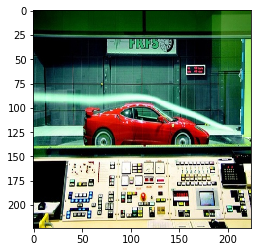

In [88]:
np_batch_inputs = batch_inputs.numpy()
i = np.random.randint(0,20)
print(categories[batch_labels[i].item() + 1])
chw_image = np_batch_inputs[i]
print(chw_image.shape)
hwc_image = np.transpose(chw_image, (1, 2, 0))
plt.imshow(hwc_image)

In [ ]:
# train the model

In [94]:
NUM_CATEGORIES = len(categories)
NUM_CATEGORIES

20

In [95]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 35929905.90it/s]


In [96]:
for layer in model_ft.parameters():
    layer.requires_grad = False

In [97]:
num_ftrs = model_ft.fc.in_features
num_ftrs, NUM_CATEGORIES

(512, 20)

In [98]:
model_ft.fc = nn.Linear(num_ftrs, NUM_CATEGORIES)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

device: cuda:0


In [103]:
EPOCHS = 10

epoch_losses = []
epoch_accuracies = []

best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(EPOCHS):
    print('epoch:', epoch)
    running_loss = 0.0
    running_correct = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels)

        
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.apend(epoch_acc)
    print('loss:', epoch_loss, 'acc:', epoch_acc)


  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 0


RuntimeError: DataLoader worker (pid 177) is killed by signal: Bus error. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [99]:
len(dataset)

2501

In [ ]:
preds.size()

In [ ]:
outputs.size()

In [ ]:
labels

In [ ]:
preds

In [ ]:
preds_value, preds = torch.max(outputs, dim=1)
preds_value, preds
# criterion(outputs, labels)

In [ ]:
len(preds_value)

In [ ]:
print(preds_value)

In [ ]:
labels

In [ ]:
labels-1

In [ ]:
criterion(outputs, labels-1)

In [ ]:
torch.sum(preds == labels)

In [ ]:
a = torch.Tensor([1, 2])
b = torch.Tensor([1, 3])
torch.sum(a == b)

In [ ]:
t = torch.randn(2, 3)
torch.max(t, dim=1)

In [ ]:
inputs.shape

In [ ]:
to_nchw(inputs).shape

In [ ]:
train_df.iloc[0]

In [ ]:
image1_filename = train_df.iloc[0][IMAGE]
image1_filename

In [ ]:
im = cv2.imread(image1_filename)

In [ ]:
im.shape

In [ ]:
im = cv2.imread(image1_filename, 0)
im.shape

In [ ]:
np.array([im]).shape

In [ ]:
im.shape

In [ ]:
type(im)

In [ ]:
cv2.resize()

In [ ]:
import cv2
SIZE = 224
resized_im = cv2.resize(im, (SIZE, SIZE))
plt.imshow(resized_im)

In [ ]:
resized_im = cv2.resize(im, (SIZE, SIZE))
plt.imshow(resized_im)

In [ ]:
scaled_item = scale(item[IMAGE], item[CATEGORY])
len(scaled_item) 

In [ ]:
scaled_x, scaled_y = scaled_item
scaled_x.shape

In [ ]:
scaled_y

In [ ]:
train_df.iloc[0]

In [ ]:
def show_random_image():
    item = dataset[np.random.randint(0, 100)]
    print(categories[item[CATEGORY]])
    plt.imshow(item[IMAGE])

show_random_image()

In [ ]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

next(iter(dataloader))

In [ ]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloader))

In [ ]:
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [ ]:
classes

In [ ]:
train_filenames

In [ ]:
train_image_w_area

In [ ]:
# object classification

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
for layer in model.parameters():
    layer.requires_grad = False

In [ ]:
fc_in_features = model.fc.in_features
fc_in_features

In [ ]:
model.fc = nn.Linear(fc_in_features, len(categories))

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# need to read images with "skimage" or "cv2" and do DataSet / DataLoader config first before running model

In [ ]:
from skimage import io

In [ ]:
image0 = io.imread(list(IMAGE_PATH.iterdir())[0])
image0.shape